In [1]:
import pandas as pd
import pandas_datareader as pdr

C:\Users\LENOVO\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
df = pd.read_csv('reliance.csv')

In [3]:
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN,NaN,NaN
1,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,NaN,NaN,NaN
2,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,NaN,NaN,NaN
3,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,NaN,NaN,NaN
4,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,NaN,NaN,NaN


In [4]:
df.isna().sum()

Date                     0
Symbol                   0
Series                   0
Prev Close               0
Open                     0
High                     0
Low                      0
Last                     0
Close                    0
VWAP                     0
Volume                   0
Turnover                 0
Trades                2851
Deliverable Volume     514
%Deliverble            514
dtype: int64

In [5]:
df2 = df.drop(['Trades', 'Deliverable Volume', '%Deliverble'], axis = 1)

In [6]:
df2.shape

(5059, 12)

In [7]:
df2.tail()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover
5054,2020-04-24,RELIANCE,EQ,1370.90,1350.15,1494.95,1347.20,1425.8,1417.00,1431.67,61711388,8.835030e+15
5055,2020-04-27,RELIANCE,EQ,1417.00,1434.00,1475.00,1423.00,1431.0,1429.75,1448.31,26736512,3.872270e+15
5056,2020-04-28,RELIANCE,EQ,1429.75,1450.00,1455.45,1392.15,1430.0,1428.15,1421.22,35866381,5.097411e+15
5057,2020-04-29,RELIANCE,EQ,1428.15,1444.90,1453.65,1420.00,1427.0,1426.95,1436.42,17141540,2.462240e+15
5058,2020-04-30,RELIANCE,EQ,1426.95,1453.95,1494.95,1438.05,1464.0,1466.00,1467.88,32617901,4.787926e+15


In [8]:
df3 = df2.reset_index()['Close']

In [9]:
df3.head()

0    251.70
1    271.85
2    282.50
3    294.35
4    314.55
Name: Close, dtype: float64

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

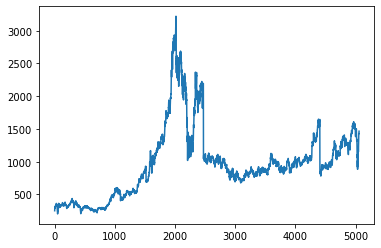

In [11]:
plt.plot(df3)

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df3 =scaler.fit_transform(np.array(df3).reshape(-1,1))

In [13]:
#Splitting data into training data and test data
training_size = int(len(df3)*0.65)
test_data = int(len(df3) - training_size)
train_data, test_data = df3[0:training_size,:], df3[training_size:len(df3),:1]

In [14]:
train_data.shape, test_data.shape

((3288, 1), (1771, 1))

In [15]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [16]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [17]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [18]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [19]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=10,batch_size=64,verbose=1)

Train on 3187 samples, validate on 1670 samples
Epoch 1/10
3187/3187 [==============================] - 36s 11ms/sample - loss: 0.0082 - val_loss: 0.0011
Epoch 2/10
3187/3187 [==============================] - 22s 7ms/sample - loss: 0.0012 - val_loss: 6.8237e-04
Epoch 3/10
3187/3187 [==============================] - 25s 8ms/sample - loss: 0.0011 - val_loss: 7.2993e-04
Epoch 4/10
3187/3187 [==============================] - 24s 8ms/sample - loss: 9.7066e-04 - val_loss: 6.0472e-04
Epoch 5/10
3187/3187 [==============================] - 24s 8ms/sample - loss: 8.8630e-04 - val_loss: 5.1896e-04
Epoch 6/10
3187/3187 [==============================] - 25s 8ms/sample - loss: 7.6793e-04 - val_loss: 4.7473e-04
Epoch 7/10
3187/3187 [==============================] - 26s 8ms/sample - loss: 7.9014e-04 - val_loss: 5.6861e-04
Epoch 8/10
3187/3187 [==============================] - 25s 8ms/sample - loss: 7.2218e-04 - val_loss: 4.3851e-04
Epoch 9/10
3187/3187 [==============================] - 25s 8ms

In [22]:
import tensorflow as tf

In [23]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [24]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [25]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

1143.6756145347756

In [26]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

1111.7044145686548

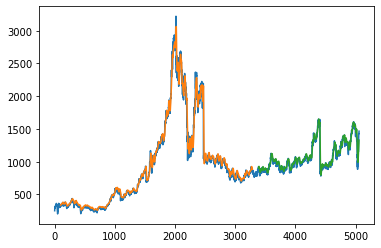

In [28]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df3)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df3)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df3)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df3))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [29]:
len(test_data)

1771

In [31]:
x_input=test_data[1671:].reshape(1,-1)
x_input.shape

(1, 100)

In [32]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [33]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.39222172]
101
1 day input [0.44793134 0.45379683 0.45026759 0.45041671 0.45233874 0.45721008
 0.45180853 0.45051613 0.45487383 0.46617401 0.4625785  0.45339917
 0.44513115 0.43484168 0.44377247 0.44438553 0.43439431 0.43291966
 0.44143622 0.44204928 0.43023545 0.43789041 0.43409607 0.44564479
 0.44552881 0.44421984 0.43948105 0.43764187 0.44229781 0.45658045
 0.44045864 0.44097228 0.44079002 0.43863602 0.43687969 0.43190894
 0.42037678 0.42306099 0.41109804 0.40046062 0.39108246 0.39179494
 0.40534853 0.41267211 0.41575398 0.40775106 0.40839726 0.41408049
 0.41989628 0.4211721  0.42562921 0.42253078 0.41893526 0.43099763
 0.42508243 0.4114957  0.4020347  0.39394893 0.39204348 0.37295578
 0.36881348 0.37766143 0.37661757 0.36715656 0.35385151 0.30187397
 0.31493049 0.2849237  0.29894123 0.26924925 0.2666976  0.25360794
 0.23677365 0.26999486 0.22562259 0.24529021 0.29130283 0.28598413
 0.2857853  0.27413716 0.30174142 0.29070634 0.28971219 0.33234471
 0.3277219  0.33693437 0.32672775

9 day output [[0.42861953]]
10 day input [0.46617401 0.4625785  0.45339917 0.44513115 0.43484168 0.44377247
 0.44438553 0.43439431 0.43291966 0.44143622 0.44204928 0.43023545
 0.43789041 0.43409607 0.44564479 0.44552881 0.44421984 0.43948105
 0.43764187 0.44229781 0.45658045 0.44045864 0.44097228 0.44079002
 0.43863602 0.43687969 0.43190894 0.42037678 0.42306099 0.41109804
 0.40046062 0.39108246 0.39179494 0.40534853 0.41267211 0.41575398
 0.40775106 0.40839726 0.41408049 0.41989628 0.4211721  0.42562921
 0.42253078 0.41893526 0.43099763 0.42508243 0.4114957  0.4020347
 0.39394893 0.39204348 0.37295578 0.36881348 0.37766143 0.37661757
 0.36715656 0.35385151 0.30187397 0.31493049 0.2849237  0.29894123
 0.26924925 0.2666976  0.25360794 0.23677365 0.26999486 0.22562259
 0.24529021 0.29130283 0.28598413 0.2857853  0.27413716 0.30174142
 0.29070634 0.28971219 0.33234471 0.3277219  0.33693437 0.32672775
 0.31370437 0.31973556 0.33827647 0.34483787 0.34270045 0.38453764
 0.38695674 0.40223353

18 day output [[0.44323835]]
19 day input [0.44143622 0.44204928 0.43023545 0.43789041 0.43409607 0.44564479
 0.44552881 0.44421984 0.43948105 0.43764187 0.44229781 0.45658045
 0.44045864 0.44097228 0.44079002 0.43863602 0.43687969 0.43190894
 0.42037678 0.42306099 0.41109804 0.40046062 0.39108246 0.39179494
 0.40534853 0.41267211 0.41575398 0.40775106 0.40839726 0.41408049
 0.41989628 0.4211721  0.42562921 0.42253078 0.41893526 0.43099763
 0.42508243 0.4114957  0.4020347  0.39394893 0.39204348 0.37295578
 0.36881348 0.37766143 0.37661757 0.36715656 0.35385151 0.30187397
 0.31493049 0.2849237  0.29894123 0.26924925 0.2666976  0.25360794
 0.23677365 0.26999486 0.22562259 0.24529021 0.29130283 0.28598413
 0.2857853  0.27413716 0.30174142 0.29070634 0.28971219 0.33234471
 0.3277219  0.33693437 0.32672775 0.31370437 0.31973556 0.33827647
 0.34483787 0.34270045 0.38453764 0.38695674 0.40223353 0.40645867
 0.40592845 0.40553079 0.41847133 0.39222172 0.40040264 0.40715465
 0.41252002 0.416710

26 day output [[0.4554121]]
27 day input [0.43948105 0.43764187 0.44229781 0.45658045 0.44045864 0.44097228
 0.44079002 0.43863602 0.43687969 0.43190894 0.42037678 0.42306099
 0.41109804 0.40046062 0.39108246 0.39179494 0.40534853 0.41267211
 0.41575398 0.40775106 0.40839726 0.41408049 0.41989628 0.4211721
 0.42562921 0.42253078 0.41893526 0.43099763 0.42508243 0.4114957
 0.4020347  0.39394893 0.39204348 0.37295578 0.36881348 0.37766143
 0.37661757 0.36715656 0.35385151 0.30187397 0.31493049 0.2849237
 0.29894123 0.26924925 0.2666976  0.25360794 0.23677365 0.26999486
 0.22562259 0.24529021 0.29130283 0.28598413 0.2857853  0.27413716
 0.30174142 0.29070634 0.28971219 0.33234471 0.3277219  0.33693437
 0.32672775 0.31370437 0.31973556 0.33827647 0.34483787 0.34270045
 0.38453764 0.38695674 0.40223353 0.40645867 0.40592845 0.40553079
 0.41847133 0.39222172 0.40040264 0.40715465 0.41252002 0.41671091
 0.4199982  0.42264268 0.42486134 0.42681667 0.42861953 0.43033931
 0.43201497 0.43366593 0

In [34]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [35]:
len(df3)


5059

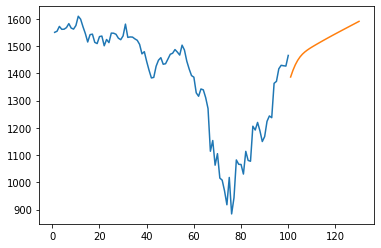

In [36]:
plt.plot(day_new,scaler.inverse_transform(df3[4959:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))